<a href="https://colab.research.google.com/github/motahareh-ehsani/MakeAIDetectFish/blob/main/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip -q /content/my_dataset.zip -d /content/

In [2]:
import os
import random
import shutil
from pathlib import Path

# Paths
base_path = Path("/content/my_dataset")
images_path = base_path / "images"
labels_path = base_path / "labels"

# Output folders
for split in ["train", "val"]:
    (base_path / "images" / split).mkdir(parents=True, exist_ok=True)
    (base_path / "labels" / split).mkdir(parents=True, exist_ok=True)

# Get all image files
image_files = list(images_path.glob("*.jpg")) + list(images_path.glob("*.jpeg")) + list(images_path.glob("*.png"))

# Shuffle
random.shuffle(image_files)

# Train/val split (80% train, 20% val)
split_idx = int(len(image_files) * 0.8)
train_files = image_files[:split_idx]
val_files = image_files[split_idx:]

def move_files(file_list, split):
    for img_path in file_list:
        # Move image
        shutil.copy(img_path, base_path / "images" / split)

        # Move label if exists
        label_file = labels_path / (img_path.stem + ".txt")
        if label_file.exists():
            shutil.copy(label_file, base_path / "labels" / split)

# Run splitting
move_files(train_files, "train")
move_files(val_files, "val")

print("✅ Split complete.")
print(f"Train: {len(train_files)} images")
print(f"Val: {len(val_files)} images")


#knowingmissingnumbersoflabeling

train_images = list((base_path / "images" / "train").glob("*.*"))
val_images = list((base_path / "images" / "val").glob("*.*"))

missing_train = [img.name for img in train_images if not (base_path / "labels/train" / (img.stem + ".txt")).exists()]
missing_val = [img.name for img in val_images if not (base_path / "labels/val" / (img.stem + ".txt")).exists()]

print(f"Train images: {len(train_images)}, Train labels: {len(train_images) - len(missing_train)}")
print(f"Val images: {len(val_images)}, Val labels: {len(val_images) - len(missing_val)}")

print(f"⚠️ Missing labels in train: {len(missing_train)}")
print(f"⚠️ Missing labels in val: {len(missing_val)}")

✅ Split complete.
Train: 3232 images
Val: 808 images
Train images: 3232, Train labels: 3228
Val images: 808, Val labels: 806
⚠️ Missing labels in train: 4
⚠️ Missing labels in val: 2


In [3]:
import os
from pathlib import Path

base_path = Path("/content/my_dataset")

def clean_split(split):
    img_dir = base_path / "images" / split
    lbl_dir = base_path / "labels" / split
    removed = 0
    for img in img_dir.glob("*.*"):
        if not (lbl_dir / (img.stem + ".txt")).exists():
            os.remove(img)
            removed += 1
    print(f"Removed {removed} unlabeled images from {split}")

clean_split("train")
clean_split("val")

Removed 4 unlabeled images from train
Removed 2 unlabeled images from val


In [4]:
import os

# Check the first few label files
label_dir = '/content/my_dataset/labels/train'
label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]

print("Sample label file contents:")
for label_file in label_files[:5]:  # Check first 5 files
    file_path = os.path.join(label_dir, label_file)
    print(f"\n{label_file}:")
    with open(file_path, 'r') as f:
        content = f.read().strip()
        print(f"'{content}'")

    # Stop if we find non-empty files
    if content:
        break

Sample label file contents:

192.168.8.119_2025-06-01_2.txt:
'0 0.201280 0.269029 0.213583 0.335958'


In [5]:
import os
from collections import defaultdict

# Configuration
CLASS_NAME = 'fish'
CLASS_ID = 0   # Using class ID 0 (YOLO standard)
DATASET_ROOT = '/content/my_dataset'

# ========== 0. Convert Class IDs from 1 to 0 ==========
def convert_class_ids(label_dir, old_id=1, new_id=0):
    """Convert all class IDs from old_id to new_id"""
    print(f"Converting class IDs from {old_id} to {new_id} in {label_dir}")

    for label_file in os.listdir(label_dir):
        if not label_file.endswith('.txt'):
            continue

        file_path = os.path.join(label_dir, label_file)
        new_lines = []
        changed = False

        with open(file_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if parts and int(parts[0]) == old_id:
                    parts[0] = str(new_id)  # Change class ID
                    new_lines.append(' '.join(parts))
                    changed = True
                else:
                    new_lines.append(line.strip())

        # Write back with updated class ID if changes were made
        if changed:
            with open(file_path, 'w') as f:
                f.write('\n'.join(new_lines))

# Convert all labels from class 1 to class 0
convert_class_ids(os.path.join(DATASET_ROOT, 'labels', 'train'), old_id=1, new_id=0)
convert_class_ids(os.path.join(DATASET_ROOT, 'labels', 'val'), old_id=1, new_id=0)

# ========== 1. Label Analysis ==========
def analyze_labels(label_path, set_name):
    """Analyze label files and count class instances."""
    class_counts = defaultdict(int)

    if not os.path.exists(label_path):
        raise FileNotFoundError(f"{set_name} labels not found at: {label_path}")

    print(f"\nAnalyzing {set_name} labels in: {label_path}")
    for label_file in os.listdir(label_path):
        if not label_file.endswith('.txt'):
            continue

        with open(os.path.join(label_path, label_file)) as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:  # class_id + at least 4 coords
                    class_id = int(parts[0])
                    class_counts[class_id] += 1

    return class_counts

# Analyze both train and val sets
train_counts = analyze_labels(os.path.join(DATASET_ROOT, 'labels', 'train'), 'Train')
val_counts = analyze_labels(os.path.join(DATASET_ROOT, 'labels', 'val'), 'Validation')

# ========== 2. Class Verification ==========
print("\nClass Distribution Summary:")
print(f"Train set: Class {CLASS_ID} instances = {train_counts.get(CLASS_ID, 0)}")
print(f"Val set: Class {CLASS_ID} instances = {val_counts.get(CLASS_ID, 0)}")

if CLASS_ID not in train_counts:
    raise ValueError(f"ERROR: Class ID {CLASS_ID} ({CLASS_NAME}) not found in training labels!")
if CLASS_ID not in val_counts and val_counts:  # Only warn if val set exists but has no class
    print(f"WARNING: Class ID {CLASS_ID} not found in validation labels!")

# ========== 3. Generate YOLOv8-Compatible YAML ==========
yaml_content = f"""path: {DATASET_ROOT}  # Root path (MUST come first)
train: images/train  # Relative to 'path'
val: images/val      # Relative to 'path'
nc: 1                # Number of classes
names: ['{CLASS_NAME}']  # Class names list

# Segmentation-specific (recommended)
mask_ratio: 4        # Downsample ratio for masks
overlap_mask: True   # Allow overlapping masks
"""

yaml_path = os.path.join(DATASET_ROOT, 'data.yaml')
with open(yaml_path, 'w') as f:
    f.write(yaml_content)

# ========== 4. Simplified Path Verification ==========
print(f"\nGenerated YAML at: {yaml_path}")
print("Contents:")
print(yaml_content)

print("\nPath Verification:")
def check_path(rel_path):
    full_path = os.path.join(DATASET_ROOT, rel_path)
    exists = os.path.exists(full_path)
    count = len(os.listdir(full_path)) if exists else 0
    print(f"{'✓' if exists else '✗'} {rel_path}: {count} files")

check_path('images/train')
check_path('images/val')
check_path('labels/train')
check_path('labels/val')

# ========== 5. Verify Conversion Worked ==========
print("\nVerifying conversion:")
sample_label = os.path.join(DATASET_ROOT, 'labels', 'train', os.listdir(os.path.join(DATASET_ROOT, 'labels', 'train'))[0])
with open(sample_label, 'r') as f:
    sample_content = f.read().strip()
    print(f"Sample label content: '{sample_content}'")
    if sample_content.startswith('0 '):
        print("✓ Successfully converted to class ID 0")
    else:
        print("✗ Conversion failed - still using different class ID")

Converting class IDs from 1 to 0 in /content/my_dataset/labels/train
Converting class IDs from 1 to 0 in /content/my_dataset/labels/val

Analyzing Train labels in: /content/my_dataset/labels/train

Analyzing Validation labels in: /content/my_dataset/labels/val

Class Distribution Summary:
Train set: Class 0 instances = 3228
Val set: Class 0 instances = 806

Generated YAML at: /content/my_dataset/data.yaml
Contents:
path: /content/my_dataset  # Root path (MUST come first)
train: images/train  # Relative to 'path'
val: images/val      # Relative to 'path'
nc: 1                # Number of classes
names: ['fish']  # Class names list

# Segmentation-specific (recommended)
mask_ratio: 4        # Downsample ratio for masks
overlap_mask: True   # Allow overlapping masks


Path Verification:
✓ images/train: 3228 files
✓ images/val: 806 files
✓ labels/train: 3228 files
✓ labels/val: 806 files

Verifying conversion:
Sample label content: '0 0.201280 0.269029 0.213583 0.335958'
✓ Successfully conv

In [6]:
yaml_content = """
train: /content/my_dataset/images/train
val: /content/my_dataset/images/val

nc: 1
names: ['fish']
"""
with open("/content/my_dataset/data.yaml", "w") as f:
    f.write(yaml_content)

print("✅ data.yaml written at /content/my_dataset/data.yaml")

✅ data.yaml written at /content/my_dataset/data.yaml


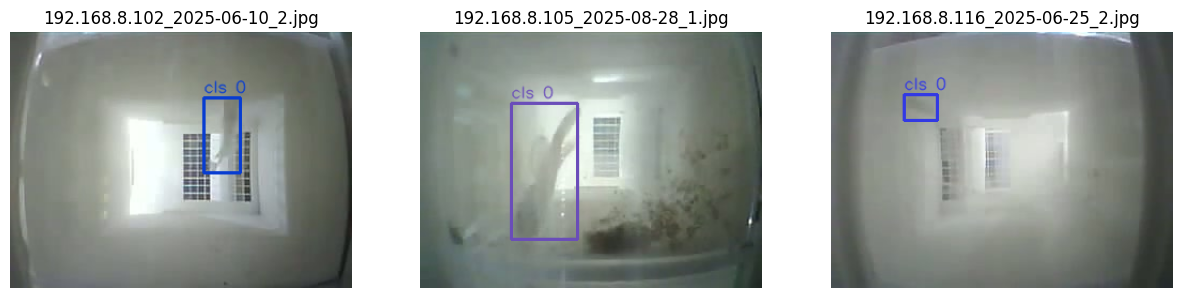

In [7]:
# box_visualization.py
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random

def visualize_boxes(dataset_root='/content/my_dataset', num_samples=3):
    img_dir = os.path.join(dataset_root, 'images', 'train')
    label_dir = os.path.join(dataset_root, 'labels', 'train')

    # Get all image files with corresponding labels
    valid_images = []
    for img_file in os.listdir(img_dir):
        base_name = os.path.splitext(img_file)[0]
        label_path = os.path.join(label_dir, f"{base_name}.txt")
        if os.path.exists(label_path):
            valid_images.append(img_file)

    num_samples = min(num_samples, len(valid_images))
    if num_samples == 0:
        print("❌ No labeled images found!")
        return

    # Randomly pick samples
    sampled_images = random.sample(valid_images, num_samples)

    plt.figure(figsize=(15, 5))
    for i, img_file in enumerate(sampled_images):
        base_name = os.path.splitext(img_file)[0]
        img_path = os.path.join(img_dir, img_file)
        label_path = os.path.join(label_dir, f"{base_name}.txt")

        img = cv2.imread(img_path)
        h, w = img.shape[:2]

        with open(label_path) as f:
            lines = f.readlines()

        # Draw YOLO bounding boxes
        for line in lines:
            parts = line.strip().split()
            if len(parts) != 5:
                continue  # not a valid YOLO bbox
            cls, x_center, y_center, bw, bh = map(float, parts)

            # Convert from YOLO format to pixel coordinates
            x_center, y_center, bw, bh = x_center * w, y_center * h, bw * w, bh * h
            x1 = int(x_center - bw / 2)
            y1 = int(y_center - bh / 2)
            x2 = int(x_center + bw / 2)
            y2 = int(y_center + bh / 2)

            color = (random.randint(0,255), random.randint(0,255), random.randint(0,255))
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img, f"cls {int(cls)}", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, color, 1, cv2.LINE_AA)

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(img_file)
        plt.axis('off')

    plt.show()

if __name__ == "__main__":
    visualize_boxes()


In [8]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.1 MB/s eta 0:00:00


In [9]:
from ultralytics import YOLO

# Load detection model (not segmentation)
model = YOLO("yolo11n.pt")   # detection model

# Train
model.train(
    data="/content/my_dataset/data.yaml",
    epochs=100,
    imgsz=640,
    batch=16
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.207 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/my_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c9d3d4eac30>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [22]:
# For even better results with object tracking
results = model.track(
    source="/content/fish_320x240.mp4",
    conf=0.25,
    tracker="bytetrack.yaml",  # Adds object tracking
    save=True,
    name="fish_tracking_output"
)

print("✅ Video processing with tracking completed!")


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/3460) /content/fish_320x240.mp4: 480x640 1 fish, 60.4ms
video 1/1 (frame 2/3460) /content/fish_320x240.mp4: 480x640 (no detections), 12.2ms
video 1/1 (frame 3/3460) /content/fish_320x240.mp4: 480x640 2 fishs, 13.0ms
video 1/1 (frame 4/3460) /content/fish_320x240.mp4: 480x640 1 fish, 9.0ms
video 1/1 (frame 5/3460) /content/fish_320x240.mp4: 480x640 1 fish, 9.9ms
video 1/1 (frame 6/3460) /content/fish_320x240.mp4: 480x640 1 fish, 8.8ms

In [23]:
from google.colab import files

# Download the tracked output video
output_path = "/content/runs/detect/fish_tracking_output/fish_320x240.mp4"

# If the above doesn't work, find the actual file:
import glob
video_files = glob.glob("/content/runs/detect/fish_tracking_output/*.mp4") + \
              glob.glob("/content/runs/detect/fish_tracking_output/*.avi")

if video_files:
    output_path = video_files[0]
    print(f"Downloading: {output_path}")
    files.download(output_path)
else:
    print("No video file found. Checking all locations...")
    !find /content/runs/detect/fish_tracking_output -type f

Downloading: /content/runs/detect/fish_tracking_output/fish_320x240.avi


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
from google.colab import drive
import shutil
from pathlib import Path
import datetime

# Mount Drive
drive.mount('/content/drive')

# Create timestamp for backup
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
backup_folder = f"/content/drive/MyDrive/fish_detection_backup_{timestamp}"

# Files to save
critical_files = [
    "/content/runs",                    # All training results
    "/content/my_dataset",              # Your dataset
    "/content/fish_320x240.mp4",        # Your video
    "/content/*.ipynb",                 # Your notebooks
]

print("🚀 Saving everything to Google Drive...")

# Save each critical item
for item in critical_files:
    try:
        if Path(item).exists():
            if Path(item).is_dir():
                shutil.copytree(item, f"{backup_folder}/{Path(item).name}", dirs_exist_ok=True)
            else:
                # Handle multiple files with wildcards
                for file in Path("/content").glob(Path(item).name):
                    shutil.copy2(file, backup_folder)
            print(f"✅ Saved: {item}")
        else:
            print(f"⚠️  Not found: {item}")
    except Exception as e:
        print(f"❌ Failed to save {item}: {e}")

print(f"✅ Backup completed: {backup_folder}")

Mounted at /content/drive
🚀 Saving everything to Google Drive...
✅ Saved: /content/runs
✅ Saved: /content/my_dataset
✅ Saved: /content/fish_320x240.mp4
⚠️  Not found: /content/*.ipynb
✅ Backup completed: /content/drive/MyDrive/fish_detection_backup_20251008_184550


In [25]:
from google.colab import files
import zipfile

# Create a zip of the most important files
important_files = [
    "/content/runs/detect/train/weights/best.pt",
    "/content/my_dataset/data.yaml",
    "/content/fish_320x240.mp4"
]

# Create zip
with zipfile.ZipFile('critical_files.zip', 'w') as zipf:
    for file in important_files:
        if os.path.exists(file):
            zipf.write(file, os.path.basename(file))
            print(f"✅ Added to zip: {file}")

# Download the zip
files.download('critical_files.zip')
print("✅ Critical files downloaded to your computer!")

✅ Added to zip: /content/runs/detect/train/weights/best.pt
✅ Added to zip: /content/my_dataset/data.yaml
✅ Added to zip: /content/fish_320x240.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Critical files downloaded to your computer!
